In [21]:
# import needed libraries
import numpy as np
import pandas as pd
from datetime import datetime 
import json
import folium
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
%matplotlib inline

In [2]:
# Convert the column to numbers
def pd_column_to_number(df,col_name):
    """
    Convert number in strings to number

    Args:
        df(dataframe): a pandas dataframe to perform the conversion on
        col_name (list): a list of column headers
    Returns:
        df: dataframe with numbers
    """
    
    for c in col_name:
        df[c] = [string_to_number(x) for x in df[c]]
    return df

In [3]:
# Convert a number in accounting format from string to float
def string_to_number(s):
    """
    Convert number in accounting format from string to float.

    Args:
        s: number as string in accounting format
    Returns:
        float number
    """

    if type(s).__name__=="str":
        s = s.strip()
        if s =="-":
            s = 0
        else:
            s = s.replace(",","").replace("$","")
            if s.find("(")>=0 and s.find(")")>=0:
                s = s.replace("(","-").replace(")","")
    return float(s)

In [4]:
# Correct certain mis-specified years
def fix_date_year(df, col_1, col_2):
    """
    Some approval dates are stored incorrectly (e.g. 2069 instead of 1969).  This function fixes it.

    Args:
        df: the dataframe 
        col_1: the col that contains the incorrect date
        col_2: the col that contains the correct reference year
    Returns:
        df: updated dataframe
    """

    for idx, date in enumerate(df[col_1]):
        year1 = date.year
        year2 = df.loc[idx, col_2]
        if np.abs(year1-year2)>95:
            year1 -=100
            df.loc[idx, col_1]=df.loc[idx, col_1].replace(year=year1)
    return df

In [7]:
# Read in raw data from csv and perform cleaning
df = pd.read_csv('../data/SBAnational.csv', parse_dates=['ApprovalDate','ApprovalFY'])
# Create new column to collapse NAICS to sector level
df['Sector'] = [int(str(x)[:2]) for x in df['NAICS']] 
# Convert approval year 1976A to 1976
df.loc[df['ApprovalFY']=='1976A','ApprovalFY']='1976'  
df['ApprovalFY'] = df['ApprovalFY'].astype(int)
# Create 'NewBiz' column as boolean
df['NewBiz'] = df['NewExist'].map({0:1, 1:0, 2:1})  
# Create 'Franchise' boolean to replace 'FranchiseCode'
df['Franchise'] = [0 if (x==1 or x==0) else 1 for x in df['FranchiseCode']]  
# Create 'RevLine' boolean to replace 'RevLineCr' that may have mis-recorded entries
df['RevLine'] = df['RevLineCr'].map({0:0, 1: 1, 2:1, 3:1, 4:1, 5:1, 7:1, 'A':1, 'C':0, 'N':0, 'Q':1, 'R':1, 'T':1, 'Y':1})
# Create 'LowDocu' boolean to replace 'LowDoc' that has entries in both 0&1 and 'N'&'Y' entries
df['LowDocu'] = df['LowDoc'].map({0:0, 1:1, 'N':0, 'Y':1})
# Create 'Default' boolean to replace 'MIS_Status'.  This is the label to be predicted.
df['Default'] = df['MIS_Status'].map({'P I F':0, 'CHGOFF': 1})
cols = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
# Calling the function to convert accounting formated numbers (as string) to float
df = pd_column_to_number(df, cols)
# Rename certain columns
df = df.rename(columns={'LoanNr_ChkDgt':'LoanNr', 'NoEmp':'NumEmp', 'DisbursementDate':'DisburseDate', 'DisbursementGross':'DisburseGross'})
df_loan = df[['LoanNr','State','Bank','BankState','Sector','ApprovalDate','ApprovalFY','Term','NumEmp','NewBiz',
              'CreateJob','RetainedJob','Franchise','UrbanRural','LowDocu','DisburseDate','DisburseGross','GrAppv','SBA_Appv','Default']]
# Calling the function to fix incorrect year
df_loan = fix_date_year(df_loan, 'ApprovalDate', 'ApprovalFY')
# Drop entries that have missing values since there are enough data points
df_loan = df_loan.dropna()

/Users/allison/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
# Read in a separate data source - the monthly unemployment data and 
# merge with the the loan data on the same year/month
us_unemploy = pd.read_csv('../data/us_unemployment.csv', index_col=0)
ur = us_unemploy.values.reshape(-1,1)[:-8]
date_range = pd.date_range('1965-01','2020-05', freq='M')

df_ur = pd.DataFrame(data=ur, index=date_range, columns=['U_rate'])
df_ur['Date'] = df_ur.index

df_new = pd.merge(df_loan.assign(grouper=df_loan['ApprovalDate'].dt.to_period('M')),
                  df_ur.assign(grouper=df_ur['Date'].dt.to_period('M')),
                  how='left', on='grouper')
df_new.drop(['grouper','Date'], axis=1, inplace=True)

df = df_new
#df.to_pickle('data/pickled_loan')   # store the data in pickle format when needed 

In [10]:
def heatmap_state(df, cols, legend, color='YlGn'):
    """ 
    Heat-map to plot variable by the U.S. states.
    
    Args:
        df(dataframe): pandas dataframe that contains the data to plot
        col(list): the col name for which the map should be plotted, col[0] contains states code 
        legend(str): legend to use 
        color(str): color theme to use (see https://github.com/dsc/colorbrewer-python)
    Returns:
        Folium interactive map
    """

    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
    state_geo = f'{url}/us-states.json'

    m = folium.Map(location=[48, -102], zoom_start=3)
    folium.Choropleth(
        geo_data=state_geo,
        name='choropleth',
        data=df,
        columns=cols,
        key_on='feature.id',
        fill_color=color,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend
    ).add_to(m)
    folium.LayerControl().add_to(m)
    return m

In [11]:
def plot_default_rate(df, col, title, sector_dict=None, ascending=True, bins=25, cutoff=0):
    """
    Plots of loan default rate by a criterion.  If a cutoff level is given, a histogram is plotted
    of the data meeting the cutoff.  Otherwise a bar plot is generated with decreasing default rates.

    Args:
        df(dataframe): pandas dataframe that contains the data to plot
        col(str): column header to group by and plot
        title(str): plot title
        bins(int): number of bins to use for histogram
        cutoff(int): minimum number of loans needed for the data to be considered  
    Returns:
        histogram plot / bar plot
    """

    df_grouped = df.groupby(col).agg({'LoanNr': 'count', 'Default': 'mean'})
    if cutoff==0:
        if ascending:
            df_plot = df_grouped.sort_values('Default', ascending=ascending)[1:6]
            df_plot = df_plot.sort_values('Default', ascending=False)
            x_labels = []
            for i in df_plot.index:
                x_labels.append(sector_dict[i])
            ax = df_plot['Default'].plot.bar(width=0.7)
            ax.set_title(title)
            ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
            ax.set_ylim(0, 0.3)
            ax.set_xlabel('Sector')
            #ax.set_yticklabels('')
            ax.set_ylabel('Default Rate')
        else:
            df_plot = df_grouped.sort_values('Default', ascending=ascending)[0:5]
            x_labels = []
            for i in df_plot.index:
                x_labels.append(sector_dict[i])
            ax = df_plot['Default'].plot.bar(width=0.7)
            ax.set_title(title)
            ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
            ax.set_ylim(0, 0.3)
            ax.set_xlabel('Sector')
            ax.set_ylabel('Default Rate')
    else:
        df_plot = df_grouped[df_grouped['LoanNr']>cutoff].sort_values('Default', ascending=False)
        ax = df_plot['Default'].plot.hist(bins=bins)
        ax.set_title(title)
        ax.set_xlabel('Default Rate')
        ax.set_ylabel('Frequency')

In [12]:
def plot_pca_explained_var(ax, pca):
    """
    Plots the percentage of total var explained by each additional pca.

    Args:
        ax: axis on which to plot
        pca: the principal components
    Returns:
        A line plot with a horizontal line at 90%
    """
    
    total_var = np.sum(pca.explained_variance_)
    cumsum_var = np.cumsum(pca.explained_variance_)
    prop_var_expl = cumsum_var/total_var
    ax.plot(prop_var_expl, color = 'black', linewidth=2, label='Explained variance')
    ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=1)
    ax.set_ylabel('proportion of explained variance')
    ax.set_xlabel('number of principal components')
    ax.legend()

In [28]:
### Plot loan default rates by states
df_state = df.groupby('State').mean()['Default']*100
columns =['State', 'Default_Rate']
heatmap_state(df_state, columns, 'Default Rate (%)', 'YlOrRd')

In [ ]:
#Check loan default by sectors
df.groupby('Sector').agg({'LoanNr': 'count', 'Default': 'mean'})

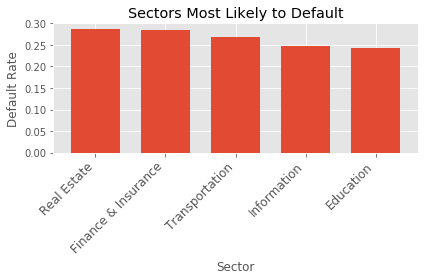

In [29]:
#Give sector names
sector_dict = {11: 'Agri, Forest, Fishing',
            21: 'Mining, Oil & Gas',
            22: 'Utilities',
            23: 'Construction',
            31: 'Manufacturing',
            32: 'Manufacturing',
            33: 'Manufacturing',
            42: 'Wholesale',
            44: 'Retail',
            45: 'Retail',
            48: 'Transportation',
            49: 'Transportation',
            51: 'Information',
            52: 'Finance & Insurance',
            53: 'Real Estate',
            54: 'Professional Services',
            55: 'Management',
            56: 'Administration and Support',
            61: 'Education',
            62: 'Health Care',
            71: 'Arts & Entertainment',
            72: 'Accommodation & Food Services',
            81: 'Other Services',
            92: 'Public Administration'}

#Plot sectors that are most likely to default
plot_default_rate(df, 'Sector', "Sectors Most Likely to Default", sector_dict, ascending=False)
plt.tight_layout()

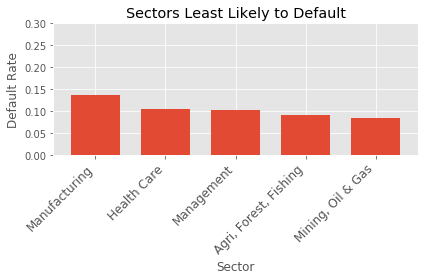

In [30]:
# Plot sectors that are least likely to default, on the same scale as 
# the chart for "Sectors Most Likely to Default"
plot_default_rate(df, 'Sector', "Sectors Least Likely to Default", sector_dict, ascending=True)
plt.tight_layout()


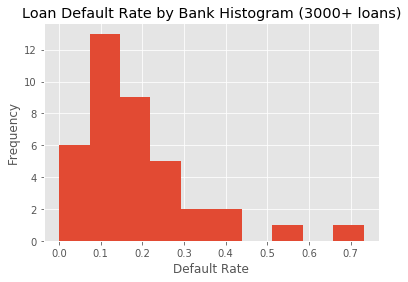

In [31]:
# Plot loan default rates by banks that issued at least 3000 loans
plot_default_rate(df, 'Bank', "Loan Default Rate by Bank Histogram (3000+ loans)", cutoff=3000, bins=10)

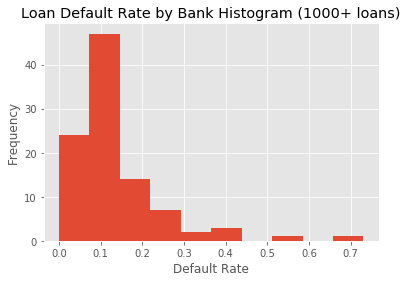

In [32]:
# Plot loan default rates by banks that issued at least 1000 loans
plot_default_rate(df, 'Bank', "Loan Default Rate by Bank Histogram (1000+ loans)", cutoff=1000, bins=10)

In [37]:
#Additional feature engineering, create new columns to put state and sector risks into buckets
df['SBA_g'] = df['SBA_Appv']/df['GrAppv']
df['StateRisk'] = df['State'].map({'FL':2, 'GA':2, 'DC':2, 'NV':2, 'IL':2, 'MI':2, 'TN':2, 'AZ':2, 'NJ':2, 'SC':2,
                                'NY':2, 'MD':2, 'KY':2, 'NC':2, 'TX':2, 'VA':2, 'CA':2, 'LA':1, 'DE':1, 'CO':1, 
                                'UT':1, 'IN':1, 'AR':1, 'AL':1, 'OH':1, 'WV':1, 'MS':1, 'OK':1, 'OR':1, 'HI':1,
                                'MO':1, 'PA':1, 'ID':1, 'CT':1, 'WA':1, 'MA':1, 'KS':1, 'WI':1, 'MN':1, 'IA':1,
                                'RI':1, 'AK':1, 'NE':1, 'NM':1, 'NH':1, 'ME':0, 'SD':0, 'ND':0, 'VT':0, 'WY':0,
                                'MT':0})
df['SectorRisk'] = df['Sector'].map({53:2, 52:2, 48:2, 51:2, 61:2, 56:2, 45:2, 23:2, 49:2, 44:2, 
                                    72:2, 71:2, 81:1, 42:1, 31:1, 54:1, 32:1, 92:1, 22:1, 33:1,
                                    62:1, 55:1, 11:0, 21:0, 0:0})

df_loan = df[['StateRisk', 'SectorRisk', 'Term', 'NumEmp','LowDocu', 'GrAppv', 'SBA_g', 'U_rate','Default']]
df_loan.to_pickle('../data/loan_data')   